# RBIG Demo

In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
import warnings
from time import time
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

# RBIG Functions
# from rbig.model import RBIG
from rbig. import RBIG

# plot utilities
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

warnings.filterwarnings('ignore') # get rid of annoying warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'RBIG' from 'rbig' (../rbig/__init__.py)

#### Toy Data

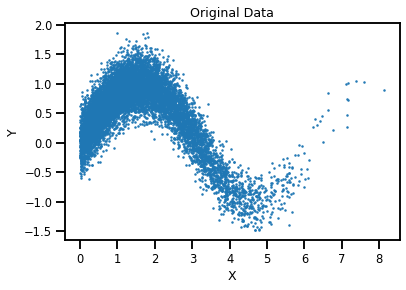

In [27]:
seed = 123
rng = np.random.RandomState(seed=seed)

num_samples = 10_000
x = np.abs(2 * rng.randn(1, num_samples))
y = np.sin(x) + 0.25 * rng.randn(1, num_samples)
data = np.vstack((x, y)).T

fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Original Data')
plt.show()

## RBIG Fitting

In [37]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 60

# Initialize RBIG class
rbig_model = RBIG(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance
)

# transform data
data_trans = rbig_model.fit_transform(data.copy())

CPU times: user 2.77 s, sys: 126 ms, total: 2.9 s
Wall time: 976 ms


### Transform Data into Gaussian

(10000, 2)


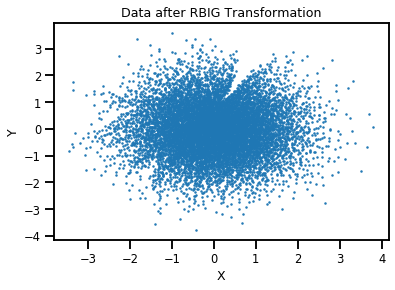

In [38]:

print(data_trans.shape)
fig, ax = plt.subplots()
ax.scatter(data_trans[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG Transformation')
plt.show()

### Invertible

In [39]:
%%time
# transform data
data_approx = rbig_model.inverse_transform(data_trans)

# check approximation
# np.testing.assert_array_almost_equal(data, data_approx, decimal=4)

CPU times: user 128 ms, sys: 996 µs, total: 129 ms
Wall time: 128 ms


#### Check Residuals

In [40]:
data_approx = rbig_model.inverse_transform(data_trans)
residual = np.abs(data - data_approx).sum().sum()

print(f'Residual from Original and Transformed: {residual:.2e}')

Residual from Original and Transformed: 6.98e+00


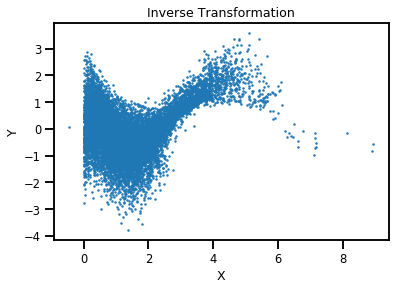

In [41]:
fig, ax = plt.subplots()
ax.scatter(data_approx[:, 0], data_trans[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Inverse Transformation')
plt.show()

### Information Reduction

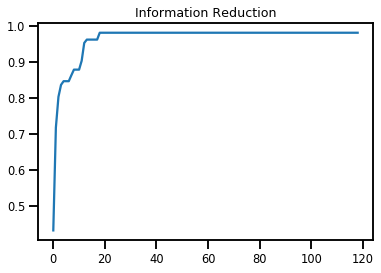

In [36]:
residual_info = rbig_model.residual_info

fig, ax = plt.subplots()
ax.plot(np.cumsum(rbig_model.residual_info))
ax.set_title('Information Reduction')
plt.show()

### Generated Synthetic Data

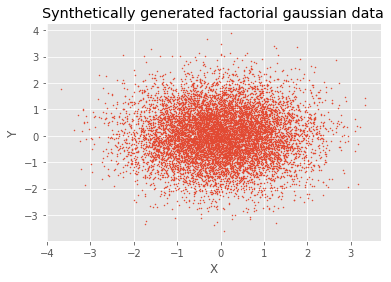

In [82]:
data_synthetic = rng.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots()
ax.scatter(data_synthetic[:, 0], data_synthetic[:, 1], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated factorial gaussian data')
plt.show()

### Synthesize New Data from RBIG Model

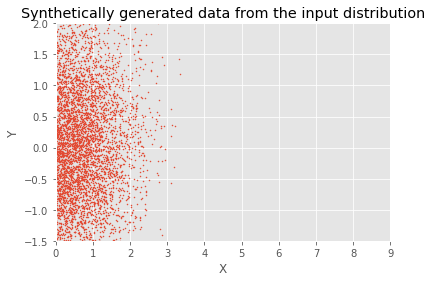

In [88]:
data_original_synthetic = rbig_model.inverse_transform(data_synthetic)

fig, ax = plt.subplots()
ax.scatter(data_original_synthetic[:, 0], data_original_synthetic[:, 1], s=1)
# ax.scatter(data[:, 0], data[:, 1], s=1)

ax.set_ylim([-1.5, 2.0])
ax.set_xlim([0.0, 9.0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Synthetically generated data from the input distribution')
plt.show()

### Jacobian

In [89]:
%%time

jacobian = rbig_model.jacobian(data, return_X_transform=False)

print(jacobian.shape)

print(f"Jacobian - min: {jacobian.min():.3e}, max: {jacobian.max():.3e}")

(10000, 2, 2)
Jacobian - min: 0.000e+00, max: 1.000e+00
CPU times: user 922 µs, sys: 1.02 ms, total: 1.94 ms
Wall time: 1.58 ms


### Estimating Probabilities with RBIG

In [90]:
%%time
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)
print(f"Prob Input Domain - min: {prob_input.min():.3e}, max: {prob_input.max():.3e}")
print(f"Prob Gauss Domain - min: {prob_gauss.min():.3e}, max: {prob_gauss.max():.3e}")
print(f"Det:: {rbig_model.det_jacobians:.3e}")

Prob Input Domain - min: 2.713e-16, max: 1.588e-01
Prob Gauss Domain - min: 2.713e-16, max: 1.588e-01
Det:: 1.000e+00
CPU times: user 6.96 ms, sys: 929 µs, total: 7.89 ms
Wall time: 6.88 ms


### Original Data with Probabilities

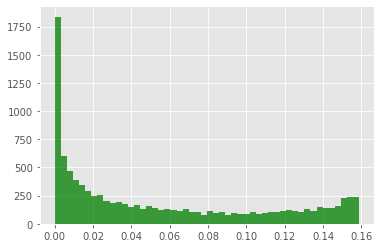

In [91]:
fig, ax = plt.subplots()
ax.hist(prob_input, 50, facecolor='green', alpha=0.75)
plt.show()

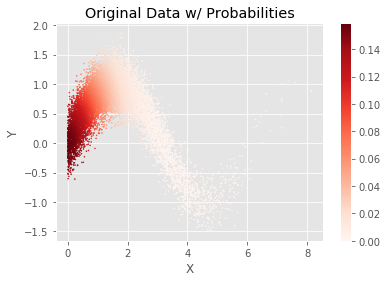

In [92]:
fig, ax = plt.subplots()

h = ax.scatter(data[:, 0], data[:, 1], s=1, c=prob_input, cmap='Reds')

ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(h, )
ax.set_title('Original Data w/ Probabilities')
plt.show()

### Probability in Gaussian Domain

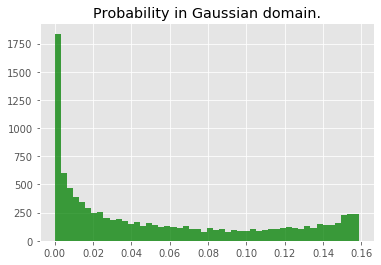

In [93]:
# Plot the probability of the data in the Gaussian Domain
fig, ax = plt.subplots()

n, bins, patches = ax.hist(prob_gauss, 50, facecolor='green', alpha=0.75)
ax.set_title('Probability in Gaussian domain.')
plt.show()

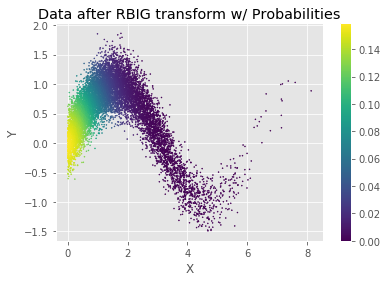

In [94]:
# Plot the Probabilities of the data using colors
fig, ax = plt.subplots()
g = ax.scatter(data_trans[:, 0], data_trans[:, 1],
               s=1, c=prob_gauss)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Data after RBIG transform w/ Probabilities')
plt.colorbar(g)
plt.show()

## Benchmarks

In [97]:
data = np.random.randn(100_000, 100)

In [98]:
%%time 

n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 10

# Initialize RBIG class
rbig_model = RBIG(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance,
    pdf_resolution=50,
)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 1min 59s, sys: 28.2 s, total: 2min 28s
Wall time: 31.6 s


In [99]:
rbig_model.n_layers

0

In [69]:
from rbig.model import RBIG as RBIG11

In [70]:
%%time 
n_layers = 1000
rotation_type = 'pca'
random_state = 123
zero_tolerance = 60
verbose=0
method = 'custom'

# Initialize RBIG class
rbig_model = RBIG11(
    n_layers=n_layers, 
    rotation_type=rotation_type, 
    random_state=random_state, 
    zero_tolerance=zero_tolerance,
    verbose=verbose,
    method=method,
    pdf_resolution=50,
)

# transform data
data_trans = rbig_model.fit_transform(data)

CPU times: user 8min 13s, sys: 1min 25s, total: 9min 38s
Wall time: 1min 58s


In [21]:
residual_info = rbig_model.residual_info
plt.

In [36]:
%%time

data_inverted = rbig_model.inverse_transform(data_trans)

CPU times: user 4min 10s, sys: 29.9 s, total: 4min 40s
Wall time: 32.4 s


In [37]:
%%time
prob_input, prob_gauss = rbig_model.predict_proba(data, domain='both', n_trials=1)

KeyboardInterrupt: 

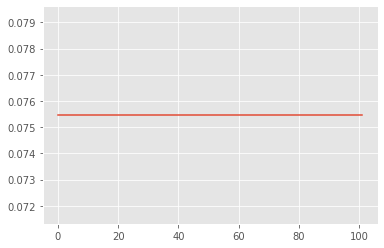

In [39]:
plt.plot(np.cumsum(rbig_model.residual_info))